- Your architecture should consist of a single hidden layer with up to k nodes.
- You can use any activation function (e.g., sigmoid, tanh, etc.) in the hidden nodes.
- Your model must use a bias term at the input and hidden layers. It can be a standalone term or
be incorporated in the weight matrices.
- You should use gradient descent to train your FFNN.
- You may find it helpful to use random number seeds for reproducibility when debugging.
- You do not need to use a GPU for this assignment, and your models should train in less than one
minute each.
- You are responsible for selecting hyperparameters (e.g., number of hidden nodes, learning rate,
training epochs, batch sizes, early stopping criteria, lambda, etc.). The goal is to get “good”
performance from your model, but an exhaustive hyper-parameter search is unnecessary.
- All code, exhibits and answers to free-response questions must be in a single Jupyter notebook.
- Your code should use parameters to control all functionality needed to complete specific tasks
(see below).

In [1]:
import torch

torch.manual_seed(42)

In [2]:
'''
Define model
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleLayerFFNN(nn.Module):
    def __init__(self, hidden_size, activation_fn="sigmoid"):
        super(SingleLayerFFNN, self).__init__()

        self.input_layer = nn.Linear(2, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, 2, bias=True)

        if activation_fn == "sigmoid":
            self.activation = torch.sigmoid
        elif activation_fn == "tanh":
            self.activation = torch.tanh
        elif activation_fn == "relu":
            self.activation = torch.relu

    def forward(self, x):
        # One hidden layer
        hidden = self.activation(self.input_layer(x))
        output = self.output_layer(hidden)

        return output

In [16]:
'''
Train model
'''

import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # loss for this epoch
        epoch_loss = 0
        for data, target in train_loader:
            target = target.long()
            optimizer.zero_grad() # reset gradients
            output = model(data) # forward pass
            loss = criterion(output, target) # calculate loss
 
            loss.backward() # backpropagation
            optimizer.step() # take step based on gradients and lr

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [17]:
'''
Take in raw csv file path and batch size, return DataLoader object
'''

import csv
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_data(file_path, batch_size):
    inputs = []
    labels = []

    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            labels.append(float(row[0]))
            inputs.append([float(row[1]), float(row[2])])

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(inputs_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)

    return loader


In [18]:
'''
Train model with train set. 
Hyperparameters: hidden_size, batch_size, num_epochs, learning_rate
'''

file_path = "xor_train.csv"

# hidden_size from [2, 3, 5, 7, 9] 
hidden_size = 7
batch_size = 8
# activation from "sigmoid", "relu", "tanh"
activation_fn = "relu"
num_epochs = 100
learning_rate = 1

train_loader = load_data(file_path, batch_size)
model = SingleLayerFFNN(hidden_size, activation_fn)

train_model(model, train_loader, num_epochs, learning_rate)

tensor([[-0.0693,  0.2672],
        [-0.3844,  0.3769],
        [ 0.0857,  0.2786],
        [-0.4587,  0.5683],
        [ 0.0417,  0.2716],
        [-0.0639,  0.2254],
        [-0.2077,  0.3004],
        [-0.2361,  0.3018]], grad_fn=<AddmmBackward0>) tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([[ 0.0020,  0.1352],
        [-0.0890,  0.1421],
        [ 0.2048,  0.0681],
        [ 0.0502,  0.0995],
        [ 0.0083,  0.1055],
        [-0.0767,  0.1937],
        [-0.0238,  0.1224],
        [-0.0276,  0.2093]], grad_fn=<AddmmBackward0>) tensor([1, 1, 0, 0, 0, 1, 0, 0])
tensor([[ 0.1611, -0.0322],
        [ 0.0408,  0.0006],
        [ 0.3380, -0.1763],
        [ 0.1613, -0.0636],
        [ 0.1290, -0.0316],
        [ 0.0914,  0.0557],
        [ 0.1889,  0.0943],
        [ 0.1440, -0.0319]], grad_fn=<AddmmBackward0>) tensor([1, 1, 0, 1, 0, 0, 0, 1])
tensor([[ 0.0532,  0.0542],
        [ 0.0849, -0.0119],
        [ 0.1254,  0.0079],
        [ 0.1224,  0.0095],
        [ 0.2555,  0.0724],
        

In [21]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # between the probabilities for 0 and 1, pick higher
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    all_preds = torch.tensor(all_preds).squeeze()
    all_targets = torch.tensor(all_targets)
    
    correct = (all_preds == all_targets).sum().item()
    total = len(all_targets)
    accuracy = correct / total
    
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [22]:
eval_file_path = "spiral_test.csv"
eval_batch_size = 4

eval_loader = load_data(eval_file_path, eval_batch_size)
evaluate_model(model, eval_loader)

Accuracy: 0.5050


0.505

In [29]:
import matplotlib.pyplot as plt

def plot_loss_curves(model, train_loader, val_loader, num_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for data, target in train_loader:
            target = target.long().squeeze()
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = target.long().squeeze()
                output = model(data).squeeze()
                loss = criterion(output, target)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


tensor([[ 2.6247,  0.8822],
        [ 0.2124,  2.8145],
        [ 2.9212,  1.0106],
        [-0.6988,  2.4374]]) tensor([0, 1, 0, 1])
tensor([[-0.8848,  1.9826],
        [ 0.0417,  1.1487],
        [ 1.4137,  0.4489],
        [-0.7179,  0.6806]]) tensor([1, 0, 1, 1])
tensor([[ 0.3839,  1.0112],
        [ 3.0391,  1.0814],
        [-0.6898,  0.6710],
        [ 1.5739,  0.4388]]) tensor([0, 0, 1, 0])
tensor([[ 1.6007,  0.7810],
        [ 0.6910,  0.6806],
        [-0.6987,  2.1889],
        [-0.5114,  0.6260]]) tensor([0, 1, 1, 1])
tensor([[0.7613, 0.5424],
        [0.3539, 1.1561],
        [2.9332, 1.0148],
        [1.6444, 0.5957]]) tensor([1, 0, 0, 1])
tensor([[-1.2113,  1.3146],
        [ 0.3235,  0.7335],
        [ 2.9505,  1.0236],
        [ 1.6132,  0.4553]]) tensor([1, 0, 0, 0])
tensor([[1.5960, 0.4473],
        [0.6901, 2.0808],
        [1.5051, 0.4091],
        [1.9334, 0.5896]]) tensor([0, 1, 0, 0])
tensor([[3.4484, 1.2570],
        [0.7391, 0.9476],
        [2.8621, 0.9840],


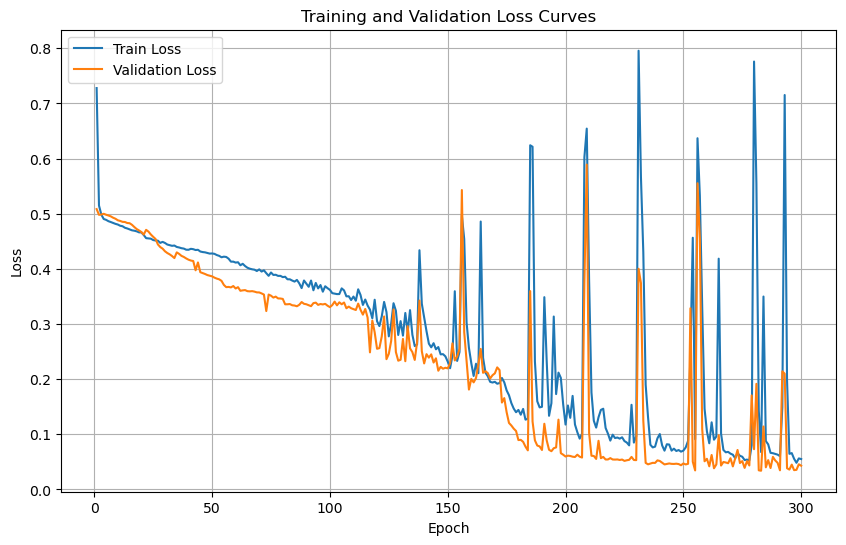

([0.7279447674751282,
  0.5148553252220154,
  0.4984219086170196,
  0.490486923456192,
  0.488969007730484,
  0.4864992320537567,
  0.4849707674980164,
  0.4832160568237305,
  0.48164068698883056,
  0.480417497754097,
  0.4782370346784592,
  0.47735027730464935,
  0.47459281742572784,
  0.47327523469924926,
  0.47167340576648714,
  0.469954696893692,
  0.4692147141695023,
  0.46811218857765197,
  0.4662356948852539,
  0.466118740439415,
  0.4613844865560532,
  0.4557260876893997,
  0.45524334132671357,
  0.4548092710971832,
  0.4522769969701767,
  0.45146448969841,
  0.45119523763656616,
  0.4471486485004425,
  0.4489776480197907,
  0.44702727675437925,
  0.4441614818572998,
  0.44295028507709505,
  0.4418424361944199,
  0.44235428094863893,
  0.43976647913455963,
  0.43882814347743987,
  0.4375116091966629,
  0.43680348694324495,
  0.43478757262229917,
  0.4346510881185532,
  0.43639242470264433,
  0.4357214343547821,
  0.4341961807012558,
  0.4346136474609375,
  0.4314996695518494,
 

In [30]:
file_path = "spiral_train.csv"

hidden_size = 7
batch_size = 8
activation_fn = "relu"
num_epochs = 300
learning_rate = 0.1

eval_file_path = "spiral_valid.csv"
eval_batch_size = 4


train_loader = load_data(file_path, batch_size)
model = SingleLayerFFNN(hidden_size, activation_fn)
eval_loader = load_data(eval_file_path, eval_batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_curves(model, train_loader, eval_loader, num_epochs, optimizer, criterion)


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_decision_surface(model, test_loader, feature_range=(-2, 2), resolution=0.01):
    """
    Plots the decision surface of the model along with the test set observations.
    
    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        feature_range: Tuple (min, max) for the grid of features.
        resolution: Step size for the grid.
    """
    # Generate a grid of points
    x_min, x_max = feature_range
    y_min, y_max = feature_range
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten the grid to feed into the model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    # Get model predictions on the grid
    model.eval()
    with torch.no_grad():
        predictions = model(grid_points_tensor)
        print(predictions)
        predicted_labels = torch.argmax(predictions, axis=1).numpy()
        print(predicted_labels)
    
    # Reshape predictions back to the grid shape
    Z = predicted_labels.reshape(xx.shape)
    
    # Plot decision surface
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    
    # Plot test data points
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()
        plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='k', cmap=plt.cm.coolwarm, s=50, label='Test Data')
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class 0',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Class 1',
               markerfacecolor='blue', markersize=10)
    ]

    plt.title('Learned Decision Surface')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(True)
    plt.show()


tensor([[ 20.9046, -15.4866],
        [ 20.9009, -15.4830],
        [ 20.8973, -15.4793],
        ...,
        [-15.0845,  12.0819],
        [-15.0890,  12.0860],
        [-15.0935,  12.0901]])
[0 0 0 ... 1 1 1]


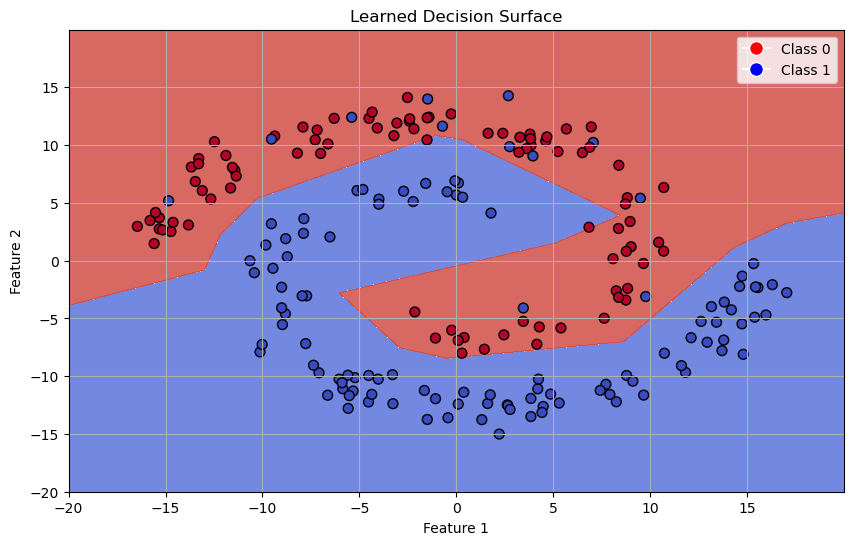

In [32]:
eval_file_path = "spiral_test.csv"
eval_batch_size = 4

test_loader = load_data(eval_file_path, eval_batch_size)
plot_decision_surface(model, test_loader, feature_range=(-20, 20), resolution=0.01)